In [1]:
import os
import requests
import collections
import torch
import torchtext 
import re
import tqdm

In [2]:
BOOK_ID = 2600
TRAIN_DATA = "train.json"
VAL_DATA = "val.json"
VOCAB_FILE = "vocab.pt"

#
# Download book and return content
#
def get_book(book_id):
    url = f"https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt"
    dest_file = f"{book_id}.txt"
    if not os.path.exists(dest_file):
        response = requests.get(url)
        f = open(dest_file, "wb")
        f.write(response.content)
        f.close()
    f = open(dest_file, "r")
    content = f.read(-1)
    f.close()
    return content

#
# Build a character-level vocabulary from the token
#
def build_vocab(token):
    counter = collections.Counter(token)
    vocab = torchtext.vocab.build_vocab_from_iterator(counter, specials=["<unk>"])
    vocab.set_default_index(0)
    return vocab

#
# A simple tokenizer that converts the input into a
# sequence of characters
#
def tokenize(text):
    #
    # Remove all unknown characters
    # 
    text = re.sub(r"[^A-Za-z0-9 \-\.;,\n\?!]", '', text)
    #
    # Replace linebreaks and multiple spaces by a single space
    #
    text = re.sub("\n+", " ", text)
    text = re.sub(" +", " ", text)
    #
    # Split into characters
    #
    return [_t for _t in text]

#
# Decode a sequence of ids
#
def decode(indices, vocab):
    return "".join(vocab.lookup_tokens(indices))


In [3]:
book = get_book(BOOK_ID)
token = tokenize(book)
vocab = build_vocab(token)
#
# Encode book
#
encoded_book = [vocab[t] for t in token]
#
# Split into train and validation set
#
total_length = len(encoded_book)
train_length = int(0.9*total_length)
print(f"Splitting file into {train_length} training items and {total_length - train_length} validation items")
train_book = encoded_book[:train_length]
val_book = encoded_book[train_length:]



Splitting file into 2852672 training items and 316964 validation items


In [4]:
#
# Default values for the parameter
#
# Inner dimension of the LSTM
D = 128
# Embedding dimension, i.e. input dimension of the LSTM
E = 32
# Number of layers
LAYERS = 4


class TheModel(torch.nn.Module):

    def __init__(self, vocab_size, hidden_dim = D, embedding_dim = E, num_layers = LAYERS, dropout = 0):
        super().__init__()
        self._embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self._lstm = torch.nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = num_layers, dropout = dropout)
        self._out = torch.nn.Linear(in_features = hidden_dim, out_features = vocab_size)

    def forward(self, x, hidden = None):
        x = self._embedding(x) # shape is now (L, B, E)
        x, hidden = self._lstm(x, hidden) # shape (L, B, H)
        x = self._out(x)
        return x, hidden

    


In [5]:
class BookDataset(torch.utils.data.Dataset):

    def __init__(self, encoded_book, window_size = 64, limit = None):
        super().__init__()
        self._encoded_book = encoded_book
        self._window_size = window_size
        #
        # For index i, we need window_size + i + 1 still to be a valid 
        # index into the encoded book, i.e. the index we can serve is constrained by
        # i  < len(book) - window_size - 1
        # so that the length of our dataset is len(book) - window_size - 1
        if limit is None:
            self._len = len(self._encoded_book) - window_size - 1
        else:
            self._len = limit
        assert self._len > 0, "Book is to short, please validate input file"
 
    def __getitem__(self, i):
        if (i < self._len):
            x = self._encoded_book[i: i + self._window_size]
            y = self._encoded_book[i + 1: i + self._window_size + 1]
            return torch.tensor(x), torch.tensor(y)
        else:
            raise KeyError

    def __len__(self):
        return self._len


#
# Collate function for batch loading
# We use the second dimension as the batch dimension
# so that the output has shape L x B
#
def collate_fn(list):
    batch_size = len(list)
    _x = []
    _y = []
    for i in list:
        x,y = i
        _x.append(x)
        _y.append(y)
    return torch.stack(_x, dim = 1), torch.stack(_y, dim = 1)


In [6]:
#
# Training parameters
#
LR = 0.001
DROPOUT = 0.2
WINDOW_SIZE = 64
EPOCHS = 7
BATCH_SIZE=1024


In [7]:
import time
#
# A simple training loop
#
def train(model, epochs, train_data_loader, val_data_loader, lr = LR, device = "cpu", log_steps = 250):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = torch.nn.functional.cross_entropy
    steps = 0    
    start_logging_period = time.time()
    model.train()
        
    for epoch in range(epochs):
        start_epoch = time.time()
        for x, y in tqdm.tqdm(train_data_loader,desc = f"Epoch {epoch}"):
            steps += 1
            optimizer.zero_grad()

            f, _ = model(x.to(device))
            V = f.shape[2]
            f = f.view(-1, V)            
            y = y.to(device).flatten()
            loss = loss_fn(f, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if (0 == (steps % log_steps)):
                time_per_step = (time.time() - start_logging_period) / log_steps
                start_logging_period = time.time()
                print(f"Completed {steps} steps ({time_per_step:.3f} seconds per step), current loss is {loss.item()}")

        elapsed_time = time.time() - start_epoch
        #
        # Do validation
        #
        val_loss = 0
        items_in_val = 0
        if val_data_loader is not None:
            model.eval()
            with torch.no_grad():
                for x, y in val_data_loader:
                    f, _ = model(x.to(device))
                    f = f.view(-1, V)            
                    y = y.to(device).flatten()
                    val_loss = val_loss + loss_fn(f, y).item()
                    items_in_val += 1
            val_loss = val_loss / items_in_val
            model.train()
        print(f"Completed epoch {epoch}, validation loss is {val_loss}, duration {elapsed_time} seconds, {steps} done in total")
    
    return losses



In [8]:
train_ds = BookDataset(train_book, window_size = WINDOW_SIZE)
val_ds  = BookDataset(val_book, window_size = WINDOW_SIZE)
print(f"Using data set with {len(train_ds)} training items and {len(val_ds)} validation items")


Using data set with 2852607 training items and 316899 validation items


In [9]:
training_data = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, 
                                            collate_fn = collate_fn, 
                                            shuffle = True, 
                                            drop_last = True, 
                                            num_workers = 2)
val_data = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, 
                                            collate_fn = collate_fn, 
                                            shuffle = True, 
                                            drop_last = True)


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
V = len(vocab)
_model = TheModel(vocab_size = V,  dropout = DROPOUT).to(device)
print(_model)
losses = []
steps_per_epoch = train_ds.__len__() // BATCH_SIZE
print(f"Training for {EPOCHS} epochs ({steps_per_epoch} steps per epoch), using device {device} and batch size {BATCH_SIZE}, lr = {LR}")
start_time = time.time()
losses = train(_model, 
               epochs = EPOCHS, 
               train_data_loader = training_data,
               val_data_loader = val_data, 
               device = device, 
               log_steps = 250, 
               lr = LR)
  


TheModel(
  (_embedding): Embedding(70, 32)
  (_lstm): LSTM(32, 128, num_layers=4, dropout=0.2)
  (_out): Linear(in_features=128, out_features=70, bias=True)
)
Training for 7 epochs (2785 steps per epoch), using device cuda and batch size 1024, lr = 0.001


Epoch 0:   9%|▉         | 251/2785 [00:28<04:31,  9.34it/s]

Completed 250 steps (0.114 seconds per step), current loss is 2.9995646476745605


Epoch 0:  18%|█▊        | 501/2785 [00:54<04:06,  9.26it/s]

Completed 500 steps (0.104 seconds per step), current loss is 2.546661138534546


Epoch 0:  27%|██▋       | 751/2785 [01:21<03:47,  8.93it/s]

Completed 750 steps (0.106 seconds per step), current loss is 2.1884469985961914


Epoch 0:  36%|███▌      | 1001/2785 [01:48<03:18,  9.00it/s]

Completed 1000 steps (0.108 seconds per step), current loss is 1.9741411209106445


Epoch 0:  45%|████▍     | 1251/2785 [02:15<02:45,  9.25it/s]

Completed 1250 steps (0.109 seconds per step), current loss is 1.8640658855438232


Epoch 0:  54%|█████▍    | 1501/2785 [02:43<02:21,  9.07it/s]

Completed 1500 steps (0.111 seconds per step), current loss is 1.755682349205017


Epoch 0:  63%|██████▎   | 1751/2785 [03:11<01:54,  9.03it/s]

Completed 1750 steps (0.111 seconds per step), current loss is 1.7011827230453491


Epoch 0:  72%|███████▏  | 2001/2785 [03:38<01:24,  9.24it/s]

Completed 2000 steps (0.111 seconds per step), current loss is 1.6291804313659668


Epoch 0:  81%|████████  | 2251/2785 [04:06<01:00,  8.79it/s]

Completed 2250 steps (0.112 seconds per step), current loss is 1.5921344757080078


Epoch 0:  90%|████████▉ | 2501/2785 [04:34<00:31,  9.12it/s]

Completed 2500 steps (0.111 seconds per step), current loss is 1.5530152320861816


Epoch 0:  99%|█████████▉| 2751/2785 [05:02<00:03,  9.18it/s]

Completed 2750 steps (0.111 seconds per step), current loss is 1.5109808444976807


Epoch 0: 100%|██████████| 2785/2785 [05:06<00:00,  9.09it/s]


Completed epoch 0, validation loss is 1.5214068384232258, duration 306.3944625854492 seconds, 2785 done in total


Epoch 1:   8%|▊         | 216/2785 [00:24<04:45,  8.99it/s]

Completed 3000 steps (0.204 seconds per step), current loss is 1.4848177433013916


Epoch 1:  17%|█▋        | 466/2785 [00:52<04:13,  9.15it/s]

Completed 3250 steps (0.111 seconds per step), current loss is 1.4573642015457153


Epoch 1:  26%|██▌       | 716/2785 [01:20<03:47,  9.09it/s]

Completed 3500 steps (0.111 seconds per step), current loss is 1.4451818466186523


Epoch 1:  35%|███▍      | 966/2785 [01:48<03:22,  9.00it/s]

Completed 3750 steps (0.111 seconds per step), current loss is 1.4343540668487549


Epoch 1:  44%|████▎     | 1216/2785 [02:15<03:02,  8.61it/s]

Completed 4000 steps (0.112 seconds per step), current loss is 1.4070688486099243


Epoch 1:  53%|█████▎    | 1466/2785 [02:44<02:24,  9.15it/s]

Completed 4250 steps (0.112 seconds per step), current loss is 1.3886675834655762


Epoch 1:  62%|██████▏   | 1716/2785 [03:11<01:59,  8.98it/s]

Completed 4500 steps (0.111 seconds per step), current loss is 1.386600136756897


Epoch 1:  71%|███████   | 1966/2785 [03:39<01:30,  9.01it/s]

Completed 4750 steps (0.111 seconds per step), current loss is 1.3744481801986694


Epoch 1:  80%|███████▉  | 2216/2785 [04:07<01:02,  9.12it/s]

Completed 5000 steps (0.111 seconds per step), current loss is 1.3659141063690186


Epoch 1:  89%|████████▊ | 2466/2785 [04:35<00:35,  8.90it/s]

Completed 5250 steps (0.111 seconds per step), current loss is 1.3453865051269531


Epoch 1:  98%|█████████▊| 2716/2785 [05:03<00:07,  8.77it/s]

Completed 5500 steps (0.112 seconds per step), current loss is 1.3442890644073486


Epoch 1: 100%|██████████| 2785/2785 [05:10<00:00,  8.96it/s]


Completed epoch 1, validation loss is 1.360988477287169, duration 310.98856496810913 seconds, 5570 done in total


Epoch 2:   6%|▋         | 181/2785 [00:20<04:49,  9.01it/s]

Completed 5750 steps (0.204 seconds per step), current loss is 1.3282932043075562


Epoch 2:  15%|█▌        | 431/2785 [00:48<04:20,  9.03it/s]

Completed 6000 steps (0.112 seconds per step), current loss is 1.3210567235946655


Epoch 2:  24%|██▍       | 681/2785 [01:16<03:53,  9.00it/s]

Completed 6250 steps (0.111 seconds per step), current loss is 1.3280755281448364


Epoch 2:  33%|███▎      | 931/2785 [01:44<03:22,  9.17it/s]

Completed 6500 steps (0.111 seconds per step), current loss is 1.3344682455062866


Epoch 2:  42%|████▏     | 1181/2785 [02:11<03:00,  8.89it/s]

Completed 6750 steps (0.112 seconds per step), current loss is 1.3031132221221924


Epoch 2:  51%|█████▏    | 1431/2785 [02:40<02:35,  8.73it/s]

Completed 7000 steps (0.112 seconds per step), current loss is 1.3004746437072754


Epoch 2:  60%|██████    | 1681/2785 [03:07<02:03,  8.93it/s]

Completed 7250 steps (0.111 seconds per step), current loss is 1.3036197423934937


Epoch 2:  69%|██████▉   | 1931/2785 [03:35<01:33,  9.16it/s]

Completed 7500 steps (0.112 seconds per step), current loss is 1.2985419034957886


Epoch 2:  78%|███████▊  | 2181/2785 [04:03<01:06,  9.09it/s]

Completed 7750 steps (0.112 seconds per step), current loss is 1.2788753509521484


Epoch 2:  87%|████████▋ | 2431/2785 [04:31<00:42,  8.33it/s]

Completed 8000 steps (0.111 seconds per step), current loss is 1.2909075021743774


Epoch 2:  96%|█████████▋| 2681/2785 [04:59<00:11,  8.91it/s]

Completed 8250 steps (0.111 seconds per step), current loss is 1.2726150751113892


Epoch 2: 100%|██████████| 2785/2785 [05:11<00:00,  8.94it/s]


Completed epoch 2, validation loss is 1.3155826488359075, duration 311.3835115432739 seconds, 8355 done in total


Epoch 3:   5%|▌         | 146/2785 [00:16<05:06,  8.62it/s]

Completed 8500 steps (0.204 seconds per step), current loss is 1.2720352411270142


Epoch 3:  14%|█▍        | 396/2785 [00:44<04:22,  9.10it/s]

Completed 8750 steps (0.112 seconds per step), current loss is 1.266629934310913


Epoch 3:  23%|██▎       | 646/2785 [01:12<03:59,  8.94it/s]

Completed 9000 steps (0.112 seconds per step), current loss is 1.2605295181274414


Epoch 3:  32%|███▏      | 896/2785 [01:40<03:28,  9.08it/s]

Completed 9250 steps (0.111 seconds per step), current loss is 1.2646225690841675


Epoch 3:  41%|████      | 1146/2785 [02:08<03:01,  9.03it/s]

Completed 9500 steps (0.111 seconds per step), current loss is 1.2697135210037231


Epoch 3:  50%|█████     | 1396/2785 [02:36<02:37,  8.81it/s]

Completed 9750 steps (0.111 seconds per step), current loss is 1.2649306058883667


Epoch 3:  59%|█████▉    | 1646/2785 [03:04<02:10,  8.76it/s]

Completed 10000 steps (0.112 seconds per step), current loss is 1.2583186626434326


Epoch 3:  68%|██████▊   | 1896/2785 [03:31<01:38,  9.07it/s]

Completed 10250 steps (0.111 seconds per step), current loss is 1.2504627704620361


Epoch 3:  77%|███████▋  | 2146/2785 [03:59<01:10,  9.01it/s]

Completed 10500 steps (0.111 seconds per step), current loss is 1.2433819770812988


Epoch 3:  86%|████████▌ | 2396/2785 [04:27<00:42,  9.09it/s]

Completed 10750 steps (0.112 seconds per step), current loss is 1.2530035972595215


Epoch 3:  95%|█████████▌| 2646/2785 [04:55<00:15,  9.01it/s]

Completed 11000 steps (0.111 seconds per step), current loss is 1.2407712936401367


Epoch 3: 100%|██████████| 2785/2785 [05:11<00:00,  8.94it/s]


Completed epoch 3, validation loss is 1.296902580940222, duration 311.36900305747986 seconds, 11140 done in total


Epoch 4:   4%|▍         | 111/2785 [00:12<04:52,  9.14it/s]

Completed 11250 steps (0.202 seconds per step), current loss is 1.252968668937683


Epoch 4:  13%|█▎        | 361/2785 [00:40<04:37,  8.73it/s]

Completed 11500 steps (0.111 seconds per step), current loss is 1.2405009269714355


Epoch 4:  22%|██▏       | 611/2785 [01:08<03:59,  9.09it/s]

Completed 11750 steps (0.112 seconds per step), current loss is 1.2435894012451172


Epoch 4:  31%|███       | 861/2785 [01:36<03:34,  8.98it/s]

Completed 12000 steps (0.112 seconds per step), current loss is 1.2310340404510498


Epoch 4:  40%|███▉      | 1111/2785 [02:04<03:05,  9.01it/s]

Completed 12250 steps (0.111 seconds per step), current loss is 1.229120135307312


Epoch 4:  49%|████▉     | 1361/2785 [02:32<02:38,  8.98it/s]

Completed 12500 steps (0.112 seconds per step), current loss is 1.236557960510254


Epoch 4:  58%|█████▊    | 1611/2785 [03:00<02:11,  8.94it/s]

Completed 12750 steps (0.111 seconds per step), current loss is 1.2366726398468018


Epoch 4:  67%|██████▋   | 1861/2785 [03:28<01:46,  8.70it/s]

Completed 13000 steps (0.112 seconds per step), current loss is 1.2294689416885376


Epoch 4:  76%|███████▌  | 2111/2785 [03:55<01:14,  9.01it/s]

Completed 13250 steps (0.111 seconds per step), current loss is 1.2166868448257446


Epoch 4:  85%|████████▍ | 2361/2785 [04:23<00:46,  9.20it/s]

Completed 13500 steps (0.111 seconds per step), current loss is 1.2220007181167603


Epoch 4:  94%|█████████▍| 2611/2785 [04:51<00:19,  9.09it/s]

Completed 13750 steps (0.111 seconds per step), current loss is 1.221069574356079


Epoch 4: 100%|██████████| 2785/2785 [05:11<00:00,  8.95it/s]


Completed epoch 4, validation loss is 1.2848480581079873, duration 311.2053368091583 seconds, 13925 done in total


Epoch 5:   3%|▎         | 76/2785 [00:08<04:57,  9.11it/s]

Completed 14000 steps (0.202 seconds per step), current loss is 1.2306522130966187


Epoch 5:  12%|█▏        | 326/2785 [00:36<04:39,  8.79it/s]

Completed 14250 steps (0.112 seconds per step), current loss is 1.2271313667297363


Epoch 5:  21%|██        | 576/2785 [01:04<04:02,  9.11it/s]

Completed 14500 steps (0.111 seconds per step), current loss is 1.2187557220458984


Epoch 5:  30%|██▉       | 826/2785 [01:32<03:42,  8.80it/s]

Completed 14750 steps (0.112 seconds per step), current loss is 1.219143033027649


Epoch 5:  39%|███▊      | 1076/2785 [02:00<03:06,  9.17it/s]

Completed 15000 steps (0.112 seconds per step), current loss is 1.2215403318405151


Epoch 5:  48%|████▊     | 1326/2785 [02:28<02:42,  9.00it/s]

Completed 15250 steps (0.111 seconds per step), current loss is 1.2160032987594604


Epoch 5:  57%|█████▋    | 1576/2785 [02:56<02:13,  9.07it/s]

Completed 15500 steps (0.111 seconds per step), current loss is 1.2239692211151123


Epoch 5:  66%|██████▌   | 1826/2785 [03:24<01:47,  8.91it/s]

Completed 15750 steps (0.111 seconds per step), current loss is 1.2253355979919434


Epoch 5:  75%|███████▍  | 2076/2785 [03:52<01:19,  8.92it/s]

Completed 16000 steps (0.112 seconds per step), current loss is 1.2124030590057373


Epoch 5:  84%|████████▎ | 2326/2785 [04:20<00:53,  8.62it/s]

Completed 16250 steps (0.112 seconds per step), current loss is 1.2208473682403564


Epoch 5:  92%|█████████▏| 2576/2785 [04:47<00:22,  9.17it/s]

Completed 16500 steps (0.111 seconds per step), current loss is 1.20844304561615


Epoch 5: 100%|██████████| 2785/2785 [05:11<00:00,  8.94it/s]


Completed epoch 5, validation loss is 1.2771915324683327, duration 311.59077429771423 seconds, 16710 done in total


Epoch 6:   1%|▏         | 41/2785 [00:05<04:58,  9.18it/s]

Completed 16750 steps (0.203 seconds per step), current loss is 1.2110888957977295


Epoch 6:  10%|█         | 291/2785 [00:32<04:37,  8.97it/s]

Completed 17000 steps (0.112 seconds per step), current loss is 1.2183605432510376


Epoch 6:  19%|█▉        | 541/2785 [01:00<04:08,  9.04it/s]

Completed 17250 steps (0.112 seconds per step), current loss is 1.2246614694595337


Epoch 6:  28%|██▊       | 791/2785 [01:28<03:41,  9.02it/s]

Completed 17500 steps (0.111 seconds per step), current loss is 1.2064162492752075


Epoch 6:  37%|███▋      | 1041/2785 [01:56<03:17,  8.82it/s]

Completed 17750 steps (0.111 seconds per step), current loss is 1.2139626741409302


Epoch 6:  46%|████▋     | 1291/2785 [02:24<02:47,  8.94it/s]

Completed 18000 steps (0.112 seconds per step), current loss is 1.2182852029800415


Epoch 6:  55%|█████▌    | 1541/2785 [02:52<02:15,  9.21it/s]

Completed 18250 steps (0.112 seconds per step), current loss is 1.207981824874878


Epoch 6:  64%|██████▍   | 1791/2785 [03:20<01:49,  9.11it/s]

Completed 18500 steps (0.112 seconds per step), current loss is 1.1958818435668945


Epoch 6:  73%|███████▎  | 2041/2785 [03:47<01:22,  9.04it/s]

Completed 18750 steps (0.111 seconds per step), current loss is 1.2059664726257324


Epoch 6:  82%|████████▏ | 2291/2785 [04:15<00:54,  9.04it/s]

Completed 19000 steps (0.111 seconds per step), current loss is 1.202332854270935


Epoch 6:  91%|█████████ | 2541/2785 [04:43<00:27,  8.75it/s]

Completed 19250 steps (0.111 seconds per step), current loss is 1.2103331089019775


Epoch 6: 100%|██████████| 2785/2785 [05:11<00:00,  8.95it/s]


Completed epoch 6, validation loss is 1.2713023412574842, duration 311.2374234199524 seconds, 19495 done in total


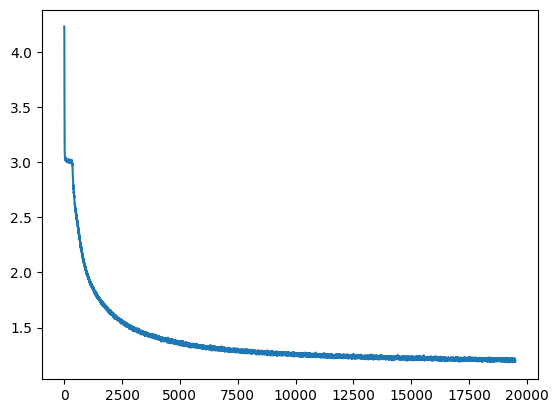

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses) 

In [12]:
#
# Sample starting with a given prompt 
# Supported methods:
# 0 - greedy search
# 1 - multinomial sampling
# 2 - top-k sampling
# 3 - top-p (nucleus) sampling
#
@torch.no_grad()
def do_sample(prompt, model, vocab, length = 50, device = "cpu", temperature = 0.7, method = 3, k_val = 5, p_val = 0.95):
    input_ids = [vocab[t] for t in tokenize(prompt)]
    hidden = None
    while (len(input_ids) < length):
        x = torch.tensor(input_ids, dtype = torch.long).to(device)
        #
        # Feed input ids into model
        #
        if hidden is None:
            f, hidden = model(x)
        else:
            f, hidden = model(x[-1].unsqueeze(dim = 0), hidden)
    	#
        # f has shape (L, V). Take last element and apply softmax as well as temperature
        #
        p = torch.softmax(f[-1] / temperature, dim = 0)
        #
        # Sample
        if 0 == method:
            idx = torch.argmax(p).item()
        elif 1 == method:
            idx = torch.distributions.categorical.Categorical(probs = p).sample().item()
        elif 2 == method:
            #
            # Sort and remove all indices after the k-th index
            #
            _, indices = torch.sort(p, descending = True)
            keep = indices[:k_val]
            #
            # Sample over the items that are left
            #
            _p = [p[i] for i in keep]
            idx = torch.distributions.categorical.Categorical(probs = torch.tensor(_p)).sample().item()
            idx = keep[idx]        
        elif 3 == method:    
            items , indices = torch.sort(p, descending = True)    
            items = iter(items.tolist())
            _sum = 0
            _k = 0
            while _sum <= p_val:
                _sum, _k =  _sum + next(items), _k + 1
            keep = indices[:_k]
            _p = [p[i] for i in keep]
            idx = torch.distributions.categorical.Categorical(probs = torch.tensor(_p)).sample().item()
            idx = keep[idx]    
        else: 
            print(f"Sampling method {method} not supported")
            exit(1)
        input_ids.append(idx)

    return decode(input_ids, vocab)


In [13]:
prompt = ". "
sample = do_sample(prompt, _model, vocab, device = device, method = 3, length = 300, temperature = .7)
#
# Strip off prompt again if we have used the default prompt
#
if prompt == ". ":
    sample = sample[len(prompt):]
print(sample)


The sun at the country was the part of his feet in the gone and stronger company with a commanding from Moscow in the front of the shoulders with a state of all that dispersed and she recalled the genius and did not want to see him. Behind the merry princess and the count stepped back to the old o
